In [4]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import chardet
import re
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer

# Word Stemming
from nltk.stem.porter import PorterStemmer

# Word Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# División estratificada
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [5]:
# Descargas de nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

# Crear una instancia del WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Crear una instancia del Porter Stemmer
stemmer = PorterStemmer()

# Crear una instancia del tokenizador
tokenizer = WhitespaceTokenizer()

# Lista de stopwords en ingles
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
# Leer el archivo con la codificacion detectada
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df[['v1', 'v2']]

In [7]:
# Funcion para mapeo de POS a primer caracter
def get_wordnet_pos(word, tag):
    """Map POS tag to the first character lemmatize() accepts"""
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag[0].upper(), wordnet.NOUN)

### Análisis de datos exploratorio (EDA)

Cantidad de spam y ham

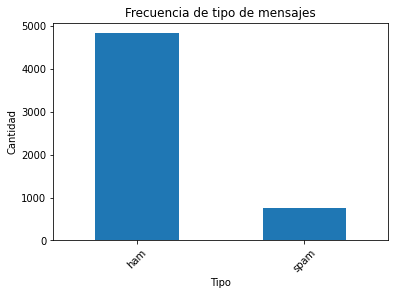

In [8]:
ax = df['v1'].value_counts().plot.bar()
plt.title('Frecuencia de tipo de mensajes')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.show()

Conjunto de entrenamiento y prueba

In [9]:
train, test = train_test_split(df.copy(), test_size=0.20, stratify=df['v1'], random_state=42)

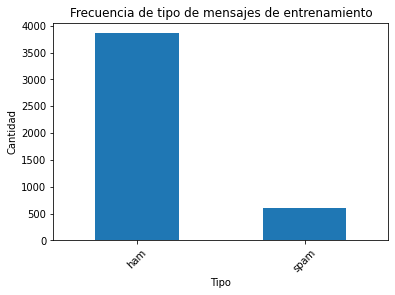

In [10]:
ax = train['v1'].value_counts().plot.bar()
plt.title('Frecuencia de tipo de mensajes de entrenamiento')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.show()

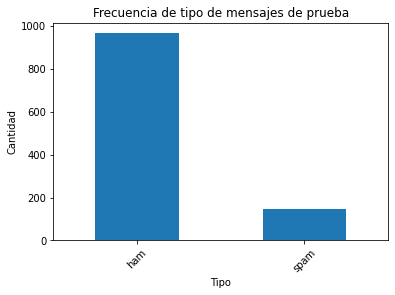

In [11]:
ax = test['v1'].value_counts().plot.bar()
plt.title('Frecuencia de tipo de mensajes de prueba')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.show()

### Limpieza de datos

Conversión a letras minúsculas

In [12]:
def lowerTexts(texts):
    return [text.lower() for text in texts]

Tokenización de los textos

In [13]:
def tokenizeTexts(texts):
    return [word_tokenize(text) for text in texts]

Eliminando tokens con signos de puntuación

In [14]:
def cleanPunctuationTexts(texts):
    return [[token for token in text if not re.search(r'\W+', token)] for text in texts]

Eliminando tokens con números

In [15]:
def cleanNumberTexts(texts):
    return [[token for token in text if not re.search(r'[0-9]+', token)] for text in texts]

Eliminando stopwords

In [16]:
def cleanStopWordTexts(texts):
    return [[token for token in text if token not in stop_words] for text in texts]

Lemmmatization

In [17]:
def lemmatizeTexts(texts):
    values = [nltk.pos_tag(text) for text in texts]
    return [[lemmatizer.lemmatize(item[0], get_wordnet_pos(item[0], item[1])) for item in value] for value in values]

Stemming

In [18]:
def stemTexts(texts):
    return  [[stemmer.stem(token) for token in text] for text in texts]

### Modelo

In [19]:
functions = [lowerTexts,tokenizeTexts,cleanPunctuationTexts,cleanNumberTexts,cleanStopWordTexts,lemmatizeTexts,stemTexts]

def textsProcessing(texts):
    for func in functions:
        texts = func(texts)

    return texts
    
texts = textsProcessing(train['v2'].tolist())

In [20]:
# Reemplazando la columna v2 por los valores obtenidos tras la limpieza
train['v2'] = texts

Construcción de los diccionarios

In [21]:
#Diccionarios para ham y spam
ham_words = {}
spam_words = {}

# Función para actualizar el diccionario de conteos
def update_word_count(word_list, word_dict):
    for word in word_list:
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 1

# Iterar sobre el DataFrame y actualizar los diccionarios según la categoría
for _, row in train.iterrows():
    if row['v1'] == 'ham':
        update_word_count(row['v2'], ham_words)
    elif row['v1'] == 'spam':
        update_word_count(row['v2'], spam_words)


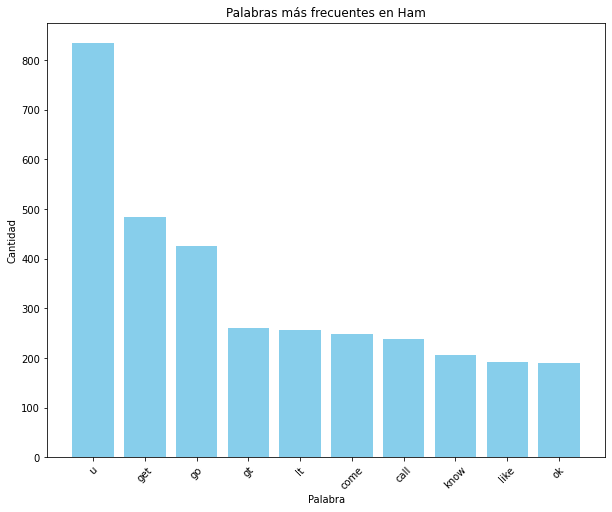

In [22]:
sorted_ham_words = sorted(ham_words.items(), key=lambda item: item[1], reverse=True)[:10]
words, counts = zip(*sorted_ham_words)  # Desempaquetar en listas separadas

# Crear la gráfica de barras
plt.figure(figsize=(10, 8))
plt.bar(words, counts, color='skyblue')
plt.title('Palabras más frecuentes en Ham')
plt.xlabel('Palabra')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

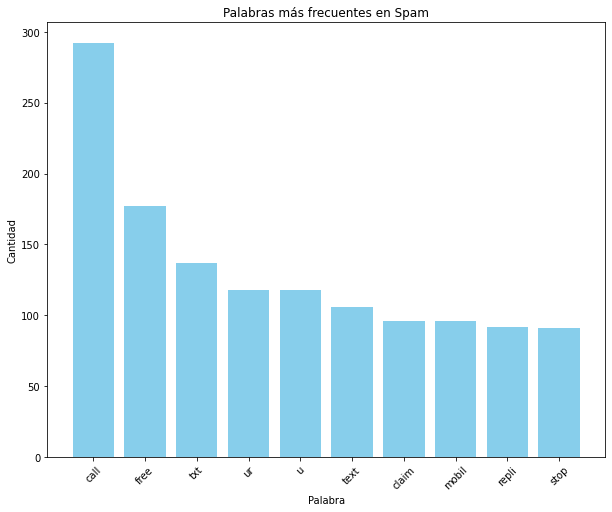

In [23]:
sorted_spam_words = sorted(spam_words.items(), key=lambda item: item[1], reverse=True)[:10]
words, counts = zip(*sorted_spam_words)  # Desempaquetar en listas separadas

# Crear la gráfica de barras
plt.figure(figsize=(10, 8))
plt.bar(words, counts, color='skyblue')
plt.title('Palabras más frecuentes en Spam')
plt.xlabel('Palabra')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

Probabilidades

In [24]:
cant_h, cant_s = train['v1'].value_counts().tolist()
cant_total = cant_h+cant_s

# P(S), P(H)
p_h = cant_h/cant_total
p_s = cant_s/cant_total

total_words_in_spam = sum(spam_words.values())
total_words_in_ham = sum(ham_words.values())

# Funcion P(S|W)
def p_s_w(word):
    # P(W|S)
    p_w_s = spam_words[word] / total_words_in_spam

    # P(W|H)
    p_w_h = ham_words[word] / total_words_in_ham

    # P(W|S) * P(S)
    numerator = p_w_s * p_s

    # [P(W|S) * P(S)] + [P(W|H) * P(H)]
    denominator = numerator + (p_w_h * p_h)

    return numerator / denominator if denominator != 0 else 0

Probabilidad total de SPAM

In [25]:
# Modelo de prediccion
def modelo(probs):
    
    numerator = 1
    denominator = 1

    for prob in probs:
        numerator*=prob
        denominator*=(1-prob)

    denominator = numerator+denominator

    # Probabilidad de que el texto sea SPAM segun las palabras identificadas
    return numerator / denominator if denominator != 0 else 0

In [26]:
# Funcion para filtrar palabras reconocidas en texto
def filterText(text):
    return [word for word in text if word in spam_words and word in ham_words]

In [27]:
# Funcion para realizar prediccion sobre texto
def textPrediction(text,result):
    # Filtrado de palabras
    text = filterText(text)
    decimals = 4

    if len(set(text))>0:
        # Listado de probabilidades de todas las palabras identificadas
        probs = [p_s_w(word) for word in text]
        res = ""

        for i in range(len(text)):
            res+=text[i]+" : "+str(round(probs[i],decimals))+","

        result["Palabras reconocidas"] = res[:-1]
        total = modelo(probs)

        result ["Probabilidad total de SPAM"] = str(round(total,decimals))

        res += "Prediccion: "
        if total>0.5:
            result["Prediccion"] = "spam"
        else:
            result["Prediccion"] = "ham"
    else:
        result["Palabras reconocidas"] = "No se han reconocido palabras."

    return result


### Pruebas de rendimiento

Funcion de Prueba

In [28]:
def prediction(category,text):
    result = dict()
    result["Categoria"] = category
    result["Texto"] = text

    test_text = textsProcessing([text])[0]

    result = textPrediction(test_text,result)

    return result


In [29]:
test_values = []
pred_values = []

for _, row in test.iterrows():
    
    result = prediction(row['v1'],row['v2'])

    if "Prediccion" in result:
        test_values.append(result["Categoria"])
        pred_values.append(result["Prediccion"])
        
    print(result)

{'Categoria': 'ham', 'Texto': "Oh right, ok. I'll make sure that i do loads of work during the day!  got a really nasty cough today and is dry n shot so that should really help it!", 'Palabras reconocidas': 'oh : 0.007,right : 0.0162,make : 0.0436,load : 0.0633,work : 0.0126,day : 0.099,get : 0.0829,today : 0.1644,n : 0.042,shot : 0.3781,help : 0.1905', 'Probabilidad total de SPAM': '0.0', 'Prediccion': 'ham'}
{'Categoria': 'ham', 'Texto': 'I am in tirupur.  call you da.', 'Palabras reconocidas': 'call : 0.4262', 'Probabilidad total de SPAM': '0.4262', 'Prediccion': 'ham'}
{'Categoria': 'ham', 'Texto': 'No that just means you have a fat head', 'Palabras reconocidas': 'No se han reconocido palabras.'}
{'Categoria': 'spam', 'Texto': 'You have won ?1,000 cash or a ?2,000 prize! To claim, call09050000327', 'Palabras reconocidas': 'cash : 0.7125', 'Probabilidad total de SPAM': '0.7125', 'Prediccion': 'spam'}
{'Categoria': 'ham', 'Texto': 'Come aftr  &lt;DECIMAL&gt; ..now i m cleaning the ho

In [30]:
matriz_confusion = confusion_matrix(test_values, pred_values,labels=["spam","ham"])
print("Matriz de Confusion:")
print(matriz_confusion)

Matriz de Confusion:
[[ 60  88]
 [  5 904]]


In [31]:
# Reporte completo
print("\nReporte de Clasificacion:")
print(classification_report(test_values, pred_values))


Reporte de Clasificacion:
              precision    recall  f1-score   support

         ham       0.91      0.99      0.95       909
        spam       0.92      0.41      0.56       148

    accuracy                           0.91      1057
   macro avg       0.92      0.70      0.76      1057
weighted avg       0.91      0.91      0.90      1057



### Funcionamiento

In [32]:
category  = input("Ingrese la categoria del mensaje\n")
text  = input("Ingrese el mensaje\n")

prediction(category,text)

{'Categoria': 'ham',
 'Texto': 'this is free',
 'Palabras reconocidas': 'free : 0.6828',
 'Probabilidad total de SPAM': '0.6828',
 'Prediccion': 'spam'}